**Fast and accurate calculations for first-passage times in Wiener diffusion models**  
Daniel Navarro, Ian Fuss (2009)

**PDF**:

$w = z/a$

\begin{align*}
f(t|v,a,w) & =\frac{\pi}{a^2}\exp\left(-vaw-\frac{v^2t}{2}\right) \times\sum_{k=1}^\infty k\exp\left(-\frac{k^2\pi^2t}{2a^2}\right)\sin(k\pi w)
\end{align*}

In [1]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import pyddm
from autograd import hessian, jacobian


def pdf(t, v, a, z, err=0.001, boundary="lower"):
    """a>0, z∈[0,a], t>0, boundary={'lower', 'upper'}"""

    if boundary == "lower":
        v = v
        w = z / a  # relative starting point (0 to 1)
    elif boundary == "upper":
        v = -v
        w = 1 - (z / a)

    tt = t / (a**2)  # normalize time

    # kl: number of terms for large t
    if np.pi * tt * err < 1:  # low error threshold
        kl = np.sqrt(-2 * np.log(np.pi * tt * err) / (np.pi**2 * tt))
        kl = max(kl, 1 / (np.pi * np.sqrt(tt)))
    else:  # high error threshold
        kl = 1 / (np.pi * np.sqrt(tt))

    # ks: number of terms for small t
    if 2 * np.sqrt(2 * np.pi * tt) * err < 1:  # low error threshold
        ks = 2 + np.sqrt(-2 * tt * np.log(2 * np.sqrt(2 * np.pi * tt) * err))
        ks = max(ks, np.sqrt(tt) + 1)
    else:  # high error threshold
        ks = 2

    # f(tt|0,1,w)
    if ks < kl:  # small t approximation
        K = int(np.ceil(ks))
        Ks = np.arange(-((K - 1) // 2), ((K - 1) // 2) + 1)
        exponent = -((w + 2 * Ks) ** 2) / (2 * tt)
        p = np.sum((w + 2 * Ks) * np.exp(exponent)) / np.sqrt(2 * np.pi * tt**3)
    else:  # large t approximation
        K = int(np.ceil(kl))
        Ks = np.arange(1, K + 1)
        exponent = -(Ks**2) * (np.pi**2) * tt / 2
        p = np.pi * np.sum(Ks * np.exp(exponent) * np.sin(Ks * np.pi * w))

    # f(t|v,a,w)
    p *= np.exp(-v * a * w - (v**2) * t / 2) / (a**2)

    return p

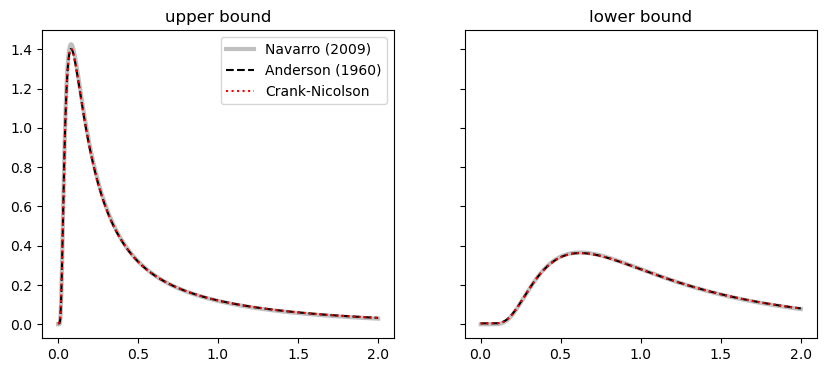

In [2]:
pyddm_params = {"v": -0.5, "a": 1, "z": 0.5}
ddm = pyddm.gddm(
    drift=pyddm_params["v"],
    bound=pyddm_params["a"],
    starting_position=pyddm_params["z"],
    nondecision=0,
    noise=1.0,
)

# anderson: ddm -> pdf
and_sol = ddm.solve_analytical()

# crank-nicolson: ddm -> pdf
cn_sol = ddm.solve_numerical_cn()

# navarro: ddm -> pdf
nav_params = {
    "v": pyddm_params["v"],
    "a": 2 * pyddm_params["a"],
    "z": pyddm_params["a"] * (pyddm_params["z"] + 1),
}

tmin, tmax, num = 0.001, 2, 500
ts = np.linspace(tmin, tmax, num)

fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharex=True, sharey=True)

pdf_upper = [pdf(t, **nav_params, boundary="upper") for t in ts]
axs[0].set_title("upper bound")
axs[0].plot(ts, pdf_upper, lw=3, c="k", alpha=0.25, label="Navarro (2009)")
axs[0].plot(
    and_sol.t_domain, and_sol.pdf(choice="correct"), ls="--", c="k", label="Anderson (1960)"
)
axs[0].plot(and_sol.t_domain, cn_sol.pdf(choice="correct"), ls=":", c="r", label="Crank-Nicolson")
axs[0].legend()


pdf_lower = [pdf(t, **nav_params, boundary="lower") for t in ts]
axs[1].set_title("lower bound")
axs[1].plot(ts, pdf_lower, lw=3, c="k", alpha=0.25)
axs[1].plot(and_sol.t_domain, and_sol.pdf(choice="error"), ls="--", c="k")
axs[1].plot(and_sol.t_domain, cn_sol.pdf(choice="error"), ls=":", c="r")

**discretization and sampling**

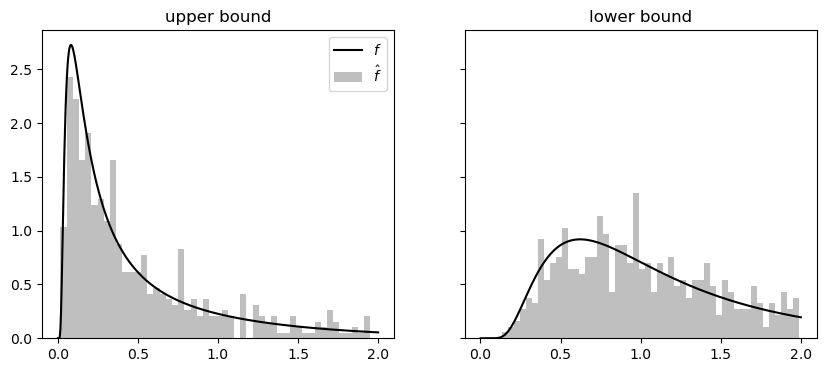

In [3]:
def sample_from_pdf(ts, v, a, z, boundary="lower", n_samples=10, seed=0):
    rng = np.random.default_rng(seed=seed)
    pdf_ = [pdf(t, v, a, z, boundary=boundary) for t in ts]
    probs_ = pdf_ / np.sum(pdf_)  # probabilities sum to 1
    return rng.choice(ts, size=n_samples, p=probs_)


n_samples = 500
samples_upper = sample_from_pdf(ts, **nav_params, boundary="upper", n_samples=n_samples)
samples_lower = sample_from_pdf(ts, **nav_params, boundary="lower", n_samples=n_samples)

fig, axs = plt.subplots(ncols=2, figsize=(10, 4), sharex=True, sharey=True)
axs[0].set_title("upper bound")
axs[0].plot(ts, pdf_upper / (np.sum(pdf_upper) * (tmax - tmin) / num), c="k", label=r"$f$")
axs[0].hist(samples_upper, bins=50, density=True, color="k", alpha=0.25, label=r"$\hat f$")

axs[1].set_title("lower bound")
axs[1].plot(ts, pdf_lower / (np.sum(pdf_lower) * (tmax - tmin) / num), c="k")
axs[1].hist(samples_lower, bins=50, density=True, color="k", alpha=0.25)
axs[0].legend()

**maximum likelihood estimation**

In [4]:
from scipy.optimize import minimize


def loss_likelihood(params, samples_upper, samples_lower, epsilon=1e-10):
    """negative log likelihood"""
    loglikelihood = 0

    likelihoods_upper = np.array([pdf(t, *params, boundary="upper") for t in samples_upper])
    loglikelihood += np.sum(np.log(likelihoods_upper + epsilon))

    likelihoods_lower = np.array([pdf(t, *params, boundary="lower") for t in samples_lower])
    loglikelihood += np.sum(np.log(likelihoods_lower + epsilon))

    return -loglikelihood


# derivates of loss_likelihood
jacobian_ = jacobian(loss_likelihood)
hessian_ = hessian(loss_likelihood)

fit = minimize(
    fun=loss_likelihood, x0=[0.1, 1, 0.1], args=(samples_upper, samples_lower), method="Nelder-Mead"
)
print(
    "   true\testimate",
    f"v: {nav_params['v']}\t{fit.x[0]:.2f}",
    f"a: {nav_params['a']}\t{fit.x[1]:.2f}",
    f"z: {nav_params['z']}\t{fit.x[2]:.2f}",
    sep="\n",
)

   true	estimate
v: -0.5	-0.63
a: 2	1.93
z: 1.5	1.43


In [5]:
hessian_inv_ = np.linalg.inv(hessian_(fit.x, samples_upper, samples_lower))
stderrs_ = np.sqrt(np.diag(hessian_inv_))
stderrs_

array([0.04558013, 0.02906234, 0.03204344])

**plot grid of loss likelihood functions**